# Preprocessing

In [1]:
MODELS_DIRECTORY = "../models"

In [43]:
import glob
import json
import random

import essentia.standard as es
from essentia.standard import (
    TensorflowPredict2D,
    TensorflowPredictEffnetDiscogs,
    TensorflowPredictMusiCNN,
)
from IPython.display import Audio
from matplotlib import pyplot as plt


In [44]:
# Get all mp3 files from data/ directory and its subdirectories
mp3_files = glob.glob("../data/sample_audio/**/*.mp3", recursive=True)

# Pick a random file
if mp3_files:
    random_file = random.choice(mp3_files)
    print(f"Selected file: {random_file}")
else:
    print("No MP3 files found in directory")

Selected file: ../data/sample_audio/audio.000/0V/0VBrgzzfLrfyJ0aIZ63DIa.mp3


In [45]:
# Load the audio file once as stereo.
# AudioLoader returns multiple outputs including the number of channels.
# (Reference: https://essentia.upf.edu/reference/std_AudioLoader.html)
audio_loader = es.AudioLoader(filename=random_file)
audio, sr, num_channels, md5, bit_rate, codec = audio_loader()

# Downmix the stereo signal to mono.
# MonoMixer requires the stereo audio and its number of channels.
# (Reference: https://essentia.upf.edu/reference/std_MonoMixer.html)
mono_mixer = es.MonoMixer(type="mix")
audio_mono = mono_mixer(audio, num_channels)

# Resample the mono audio to 44.1KHz.
# Resample takes the input signal and the input/output sampling rates.
# (Reference: https://essentia.upf.edu/reference/std_Resample.html)
resample = es.Resample(inputSampleRate=sr, outputSampleRate=44100, quality=1)
audio_mono_resampled = resample(audio_mono)

# 'audio_mono_resampled' is now a 44.1KHz mono signal ready for further processing.

In [46]:
Audio(audio_mono_resampled, rate=44100)

# BPM tempo estimation

you can either use the default settings for the RhythmExtractor2013
signal processing algorithm in Essentia or the TempoCNN ML model.

## RhythmExtractor2013


We generally recommend using [RhythmExtractor2013](https://essentia.upf.edu/reference/std_RhythmExtractor2013.html) for beat and tempo estimation. This a wrapper algorithm providing two approaches, slower and more accurate `multifeature` vs. faster `degara`, using the auxiliary [BeatTrackerMultiFeature](https://essentia.upf.edu/reference/std_BeatTrackerMultiFeature.html) and [BeatTrackerDegara](https://essentia.upf.edu/reference/std_BeatTrackerDegara.html) for beat position estimation, respectively. 

The RhythmExtractor2013 algorithm outputs the estimated tempo (BPM), time positions of each beat, and confidence of their detection (in the case of using `multifeature`). In addition, it outputs the list of BPM estimates and periods between consecutive beats throughout the entire input audio signal. The algorithm relies on statistics gathered over the whole music track, and therefore it is not suited for real-time detection.

Similarly to our *onset detection tutorial*, to sonify the results, we mark the estimated beat positions in the audio, using [AudioOnsetsMarker](http://essentia.upf.edu/documentation/reference/std_AudioOnsetsMarker.html). To save the audio to a file, we use [MonoWriter](https://essentia.upf.edu/reference/std_MonoWriter.html). Consult that tutorial for more details.

In [47]:
# Loading an audio file.
# audio = es.MonoLoader(filename=random_file)()

# Compute beat positions and BPM.
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(
    audio_mono_resampled
)

print("BPM:", bpm)
# print("Beat positions (sec.):", beats)
print("Beat estimation confidence:", beats_confidence)

BPM: 125.38145446777344
Beat estimation confidence: 2.0071487426757812


## TempoCNN

Essentia supports inference with TensorFlow models for a variety of MIR tasks, in particular tempo estimation, for which we provide the `TempoCNN` models. 

The [TempoCNN](https://essentia.upf.edu/reference/std_TempoCNN.html) algorithm outputs a global BPM estimation on the entire audio input as well as local estimations on short audio segments (patches) throughout the track. For local estimations, it provides their probabilities that can be used as a confidence measure.

To use this algorithm in Python, follow [our instructions for using TensorFlow models](https://essentia.upf.edu/machine_learning.html#using-pre-trained-tensorflow-models).

To download the model:

In [49]:
# !curl -SLO https://essentia.upf.edu/models/tempo/tempocnn/deeptemp-k16-3.pb

In [50]:
sr = 11025
audio_11khz = es.MonoLoader(filename=random_file, sampleRate=sr)()

# List the available models, let the user pick one by changing user_selection
pb_models = glob.glob(f"{MODELS_DIRECTORY}/tempo/*.pb")
if pb_models:
    print("Available TempoCNN models:")
    for i, model_file in enumerate(pb_models):
        print(f" {i}: {model_file}")
    user_selection = 0  # Change to another index to select a different model

    TempoCNN_model_path = pb_models[user_selection]
    print("Using model:", TempoCNN_model_path)
else:
    TempoCNN_model_path = f"{MODELS_DIRECTORY}/tempo/deeptemp-k16-3.pb"
    print("Using default model:", TempoCNN_model_path)

global_bpm, local_bpm, local_probs = es.TempoCNN(graphFilename=TempoCNN_model_path)(
    audio_11khz
)

print("song BPM: {}".format(global_bpm))

Available TempoCNN models:
 0: ../models/tempo/deeptemp-k16-3.pb
 1: ../models/tempo/deepsquare-k16-3.pb
Using model: ../models/tempo/deeptemp-k16-3.pb
song BPM: 126.0


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/tempo/deeptemp-k16-3.pb`


# Key

Key: use KeyExtractor algorithm to compute key and scale. Because our collection is
diverse in genres, use three different profiles for key estimation (`temperley
`
,
`krumhansl`
`
edma
,
`) so that we can compare them later. For scale detection, our
algorithm is limited to major/minor.

In [51]:
for profile in ["temperley", "krumhansl", "edma"]:
    key_extractor = es.KeyExtractor(profileType=profile)
    key, scale, strength = key_extractor(audio_mono_resampled)
    print("Profile:", profile)
    print("  Key:", key, scale)
    print("  Strength:", strength)


Profile: temperley
  Key: A major
  Strength: 0.6933034658432007
Profile: krumhansl
  Key: A major
  Strength: 0.8547758460044861
Profile: edma
  Key: A major
  Strength: 0.9159632921218872


# Loudness

use LoudnessEBUR128 to compute integrated loudness in LUFS.


Essentia provides the [LoudnessEBUR128](https://essentia.upf.edu/documentation/reference/std_LoudnessEBUR128.html) algorithm which implements a [common standard in broadcasting](https://en.wikipedia.org/wiki/EBU_R_128). It allows estimating overall loudness and its momentary and short-term fluctuations and dynamic range.

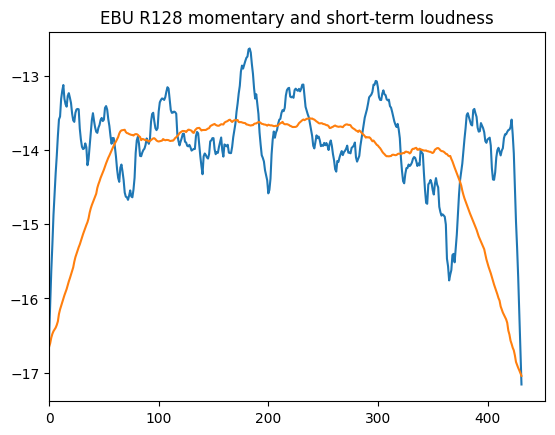

In [52]:
# LoudnessEBUR128 requires stereo in 44100 Hz sample rate
SEGMENT_LENGTH = 10

audio_st = es.StereoTrimmer(startTime=0, endTime=SEGMENT_LENGTH)(audio)
ebu_momentary, ebu_shortterm, ebu_integrated, dr = es.LoudnessEBUR128(
    hopSize=1024 / 44100, startAtZero=True
)(audio_st)

plt.plot(ebu_momentary)
plt.plot(ebu_shortterm)
plt.title("EBU R128 momentary and short-term loudness")
plt.xlim(0)
plt.show()

In [53]:
print("Integrated loudness:", ebu_integrated)
print("Dynamic range:", dr)

Integrated loudness: -13.880502700805664
Dynamic range: 2.1967554092407227


# Embeddings

Load the Audio for all extractions

In [54]:
# audio = MonoLoader(filename=random_file, sampleRate=16000, resampleQuality=4)()
audio = es.Resample(inputSampleRate=44100, outputSampleRate=16000, quality=4)(
    audio_mono_resampled
)

In [55]:
# discogs
discogs_embeddings_path = f"{MODELS_DIRECTORY}/embeddings/discogs-effnet-bs64-1.pb"
discogs_metadata_path = f"{MODELS_DIRECTORY}/embeddings/discogs-effnet-bs64-1.json"

# musicnn
musicnn_embeddings_path = f"{MODELS_DIRECTORY}/embeddings/msd-musicnn-1.pb"
musicnn_metadata_path = f"{MODELS_DIRECTORY}/embeddings/msd-musicnn-1.json"

In [56]:
discogs_model = TensorflowPredictEffnetDiscogs(
    graphFilename=discogs_embeddings_path, output="PartitionedCall:1"
)
discogs_embeddings = discogs_model(audio)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/embeddings/discogs-effnet-bs64-1.pb`


In [57]:
musicnn_model = TensorflowPredictMusiCNN(
    graphFilename=musicnn_embeddings_path, output="model/dense/BiasAdd"
)
musicnn_activations = musicnn_model(audio)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/embeddings/msd-musicnn-1.pb`


In [58]:
with open(discogs_metadata_path, "r") as json_file:
    discogs_metadata = json.load(json_file)

print(discogs_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


In [59]:
with open(musicnn_metadata_path, "r") as json_file:
    musicnn_metadata = json.load(json_file)

print(musicnn_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


# Danceability

In [60]:
danceability_metadata_path = (
    f"{MODELS_DIRECTORY}/danceability/danceability-discogs-effnet-1.json"
)
danceability_weights_path = (
    f"{MODELS_DIRECTORY}/danceability/danceability-discogs-effnet-1.pb"
)

In [61]:
with open(danceability_metadata_path, "r") as json_file:
    danceability_metadata = json.load(json_file)

print(danceability_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


In [62]:
danceability_model = TensorflowPredict2D(
    graphFilename=danceability_weights_path, output="model/Softmax"
)
danceability_predictions = danceability_model(discogs_embeddings)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/danceability/danceability-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/danceability/danceability-discogs-effnet-1.pb`


Finally, we can compute the global accuracy as the mean of the activations along the temporal axis.

In [63]:
for label, probability in zip(
    danceability_metadata["classes"], danceability_predictions.mean(axis=0)
):
    print(f"{label}: {100 * probability:.1f}%")

danceable: 36.7%
not_danceable: 63.3%


In [64]:
# use tha audio_mono_resampled

# Compute beat positions and BPM.
danceability_algo = es.Danceability()

# danceability (real) - the danceability value. Normal values range from 0 to ~3. The higher, the more danceable.
# dfa (vector_real) - the DFA exponent vector for considered segment length (tau) values

danceability, dfa = danceability_algo(audio_mono_resampled)

print("Danceability:", danceability)
# Normalize danceability to a 0-1 range
normalized_danceability = danceability / 3.0

print("Normalized Danceability:", normalized_danceability)
# print("DFA exponent vector:", dfa)

Danceability: 1.668439269065857
Normalized Danceability: 0.5561464230219523


# Valence & Arousal

In [ ]:
va_metadata_path = f"{MODELS_DIRECTORY}/valence-arousal/emomusic-msd-musicnn-2.json"
va_weights_path = f"{MODELS_DIRECTORY}/valence-arousal/emomusic-msd-musicnn-2.pb"


In [66]:
with open(va_metadata_path, "r") as json_file:
    va_metadata = json.load(json_file)

print(va_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'programming_env', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


In [68]:
va_model = TensorflowPredict2D(
    graphFilename=va_weights_path,
    output="model/Identity",
)
va_predictions = va_model(musicnn_activations)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/valence-arousal/emomusic-msd-musicnn-2.pb`


In [69]:
for label, prediction in zip(va_metadata["classes"], va_predictions.mean(axis=0)):
    # Scale the prediction from the range [1, 9] to [0, 1]
    scaled_prediction = (prediction - 1) / 8
    print(f"{label}: {100 * scaled_prediction:.1f}%")

valence: 31.7%
arousal: 58.9%


# Voice/Instrumental

In [70]:
voice_instrumental_metadata_path = (
    f"{MODELS_DIRECTORY}/voice-instrumental/voice_instrumental-discogs-effnet-1.json"
)
voice_instrumental_weights_path = (
    f"{MODELS_DIRECTORY}/voice-instrumental/voice_instrumental-discogs-effnet-1.pb"
)

with open(voice_instrumental_metadata_path, "r") as json_file:
    voice_instrumental_metadata = json.load(json_file)

print(voice_instrumental_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


In [71]:
voice_instrumental_model = TensorflowPredict2D(
    graphFilename=voice_instrumental_weights_path, output="model/Softmax"
)
voice_instrumental_predictions = voice_instrumental_model(discogs_embeddings)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/voice-instrumental/voice_instrumental-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/voice-instrumental/voice_instrumental-discogs-effnet-1.pb`


In [72]:
for label, probability in zip(
    voice_instrumental_metadata["classes"], voice_instrumental_predictions.mean(axis=0)
):
    print(f"{label}: {100 * probability:.1f}%")

instrumental: 21.2%
voice: 78.8%


# Genre / Style

In [74]:
genre_metadata_path = f"{MODELS_DIRECTORY}/genre/genre_discogs400-discogs-effnet-1.json"
genre_weights_path = f"{MODELS_DIRECTORY}/genre/genre_discogs400-discogs-effnet-1.pb"

with open(genre_metadata_path, "r") as json_file:
    genre_metadata = json.load(json_file)

print(genre_metadata.keys())

dict_keys(['name', 'type', 'link', 'version', 'description', 'author', 'email', 'release_date', 'framework', 'framework_version', 'classes', 'model_types', 'dataset', 'schema', 'citation', 'inference'])


In [75]:
genre_model = TensorflowPredict2D(
    graphFilename=genre_weights_path,
    input="serving_default_model_Placeholder",
    output="PartitionedCall:0",
)
genre_predictions = genre_model(discogs_embeddings)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/genre/genre_discogs400-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `../models/genre/genre_discogs400-discogs-effnet-1.pb`


In [76]:
sorted_genre_probabilities = sorted(
    zip(genre_metadata["classes"], genre_predictions.mean(axis=0)),
    key=lambda x: x[1],
    reverse=True,
)

for label, probability in sorted_genre_probabilities:
    print(f"{label}: {100 * probability:.1f}%")

Rock---Funk Metal: 17.0%
Rock---Alternative Rock: 14.2%
Rock---Nu Metal: 11.2%
Rock---Punk: 10.0%
Rock---Hardcore: 8.5%
Rock---Heavy Metal: 7.7%
Rock---Death Metal: 6.5%
Rock---Gothic Metal: 6.3%
Rock---Black Metal: 5.3%
Rock---Goth Rock: 5.2%
Rock---Indie Rock: 4.9%
Rock---Grunge: 4.6%
Rock---Thrash: 4.5%
Rock---Hard Rock: 4.1%
Rock---Emo: 3.9%
Rock---Symphonic Rock: 3.0%
Rock---Ska: 2.7%
Rock---Folk Rock: 2.6%
Rock---Industrial: 2.3%
Rock---Doom Metal: 2.2%
Rock---Pop Punk: 1.9%
Rock---Power Metal: 1.8%
Rock---Speed Metal: 1.8%
Rock---Melodic Death Metal: 1.7%
Rock---Melodic Hardcore: 1.7%
Rock---Brit Pop: 1.7%
Rock---Prog Rock: 1.6%
Rock---Oi: 1.6%
Rock---Glam: 1.5%
Rock---Pop Rock: 1.5%
Rock---Metalcore: 1.5%
Rock---Folk Metal: 1.5%
Rock---Progressive Metal: 1.4%
Reggae---Ska: 1.4%
Rock---Viking Metal: 1.3%
Rock---Technical Death Metal: 1.0%
Rock---Post-Hardcore: 0.8%
Rock---Psychedelic Rock: 0.8%
Rock---Arena Rock: 0.8%
Rock---Power Pop: 0.8%
Rock---Garage Rock: 0.8%
Rock---Space 